# Loon Example

## Background

This example shows how `Whatif` might be used to control flying high-altitude balloons for wireless communications. Please check details of the public [Loon Stratospheric Sensor Data](https://zenodo.org/record/5119968). Previously, Google and Loon researchers have used Reinforcement Learning to [efficiently navigate balloons in the stratosphere](https://www.nature.com/articles/s41586-020-2939-8). The basic idea is that the wind fields vary at different altitude, and by moving the ballon **vertically** between winds at different altitudes, one can keep the balloon at its desirable **horizontal** location for effective communications.

For the purpose of this demo, we extracted 128 hours of the flight `LN-191` data from the file [loon-flights-2021-Q2.csv.gz](https://zenodo.org/record/5119968/files/loon-flights-2021Q2.csv.gz?download=1) to train `Whatif`. In particular, this example shows how easy it is to use `Whatif` to:

- Behaviour cloning (altitude control actions) from data so we keep balloons on the current trajectory
- Speculate counter-factual trajectories given alternative actions (thus, answering the "**What if**" question)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import my_nb_path  # isort: skip

import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import smopy
import torch
from IPython.display import Markdown
from tqdm.autonotebook import tqdm

import a2rl as wi
from a2rl.nbtools import print  # Enable color outputs when rich is installed.

# Default to fast mode for faster runs.
os.environ["NOTEBOOK_FAST_RUN"] = "1"

# Misc. settings
plt.rcParams["figure.figsize"] = [10, 8]
RAN_SEED = 42
random.seed(RAN_SEED)
np.random.seed(RAN_SEED)
_ = torch.manual_seed(RAN_SEED)

/tmp/ipykernel_3612/3642587749.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/lightning_fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/pytorch_lightning/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/nptyping/typing_.py:51: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  Bool8 = np.bool8
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/nptyping/typing_.py:54: DeprecationWarning: `np.object0` is a deprecated alias for ``np.object0` is a deprecated alias for `np.object_`. `object` can be used instead.  (Deprecated NumPy 1.24)`.  (Deprecated NumPy 1.24)
  Object0 = np.object0
/opt/hostedtoolc

## Optional: Download and Preprocess Dataset

The next cell creates `loon/metadata.yaml` and `loon/data.csv` **only if** they are unavailable on
your disk. It extracts the first 10,000 rows representing 128 hours of the flight LN-191 data from
[loon-flights-2021-Q2.csv.gz](https://zenodo.org/record/5119968/files/loon-flights-2021Q2.csv.gz?download=1).
Depending on your internet connection, it may take a while for `pandas` to read the 35.9MB source
`.csv.gz` file over https.

- Dataset homepage: <https://zenodo.org/record/5119968>
- Source data file: <https://zenodo.org/record/5119968/files/loon-flights-2021Q2.csv.gz?download=1>
- Name: Loon Stratospheric Sensor Data
- License (for files): Creative Commons Attribution 4.0 International

In [2]:
%%time
loon_dataset = Path("loon")
loon_dataset.mkdir(exist_ok=True)

if not (loon_dataset / "metadata.yaml").exists():
    metadata = wi.Metadata(
        states=[
            "altitude",
            "temperature",
            "pressure",
            "earth_ir",
            "velocity_u",
            "velocity_v",
            "omega",
            "acceleration",
            "solar_elevation",
            "solar_azimuth",
        ],
        actions=["acs", "is_daytime"],
        rewards=["dist_to_station"],
    )
    wi.save_metadata(metadata, loon_dataset / "metadata.yaml")
    del metadata

if not (loon_dataset / "data.csv").exists():

    def create_loon_data_csv(output_path=loon_dataset / "data.csv"):
        from sklearn.metrics.pairwise import haversine_distances

        usecols = [
            "time",
            "latitude",
            "longitude",
            "altitude",
            "temperature",
            "pressure",
            "earth_ir",
            "earth_ir_sensor_config",
            "acs",
            "velocity_u",
            "velocity_v",
            "omega",
            "acceleration",
            "solar_elevation",
            "solar_azimuth",
            "is_daytime",
        ]
        df = pd.read_csv(
            "https://zenodo.org/record/5119968/files/loon-flights-2021Q2.csv.gz?download=1",
            usecols=usecols,
            dtype=str,  # To make saved output uses the same formats as the source data.
            low_memory=False,
            compression="gzip",
        )
        df.rename(columns={"time": "timestamp"}, inplace=True)
        df = df.head(10000)
        df.fillna(method="ffill", inplace=True)

        # Convert "2021-04-01T00:00:15.000Z" to timestamp (in milliseconds).
        df["timestamp"] = pd.to_datetime(df["timestamp"]).apply(lambda x: x.timestamp() * 1000)

        # Add dist_to_station, which is the distance between each row and the initial position (row 0).
        # The harvisine distance() returns a distance matrix, but we just use the 1st row which contains
        # distances of each row to the 1st row.
        earth_circle = 6371
        locs = df[["latitude", "longitude"]].values.astype(float)
        df["dist_to_station"] = haversine_distances(np.radians(locs))[0, :] * earth_circle

        df.to_csv(output_path, index=False)

    create_loon_data_csv()

del loon_dataset

CPU times: user 117 µs, sys: 10 µs, total: 127 µs
Wall time: 131 µs


## Load Dataset

In [3]:
BLOCK_SIZE_ROW = 4  # block_size (measured by # of rows) as the context to train GPT
wi_df = wi.read_csv_dataset("loon")
wi_df.add_value()

################################################################################
# To run in fast mode, set env var NOTEBOOK_FAST_RUN=1 prior to starting Jupyter
################################################################################
if os.environ.get("NOTEBOOK_FAST_RUN", "0") != "0":
    wi_df = wi_df.head(450)

    display(
        Markdown(
            '<p style="color:firebrick; background-color:yellow; font-weight:bold">'
            "NOTE: notebook runs in fast mode. Use only a fraction of data. Results may differ."
        )
    )
################################################################################

# Instantiate a tokenier given the selected dataset.
field_tokenizer = wi.DiscreteTokenizer(num_bins_strategy="uniform")
tokenizer = wi.AutoTokenizer(wi_df, block_size_row=BLOCK_SIZE_ROW, field_tokenizer=field_tokenizer)
tokenizer.df.head(2)

/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the n

<p style="color:firebrick; background-color:yellow; font-weight:bold">NOTE: notebook runs in fast mode. Use only a fraction of data. Results may differ.

altitude  temperature  pressure    earth_ir  velocity_u  velocity_v   
0  17670.827357   195.211765      80.6  287.812433       0.259      -3.145  \
1  17675.710318   195.211765      80.6  285.836360      -0.065      -3.327   

      omega  acceleration  solar_elevation  solar_azimuth  acs  is_daytime   
0  0.000198      0.006500       -22.922669      95.718685    0           0  \
1  0.000000      0.008396       -22.696175      95.605274    0           0   

   dist_to_station     value  
0         0.000000  0.198969  
1         0.195254  0.327736

In [4]:
tokenizer.df_tokenized.head(2)

altitude  temperature  pressure  earth_ir  velocity_u  velocity_v  omega   
0        57          111       200       362         432         555    624  \
1        59          111       200       353         427         553    622   

   acceleration  solar_elevation  solar_azimuth   acs  is_daytime   
0           752              800            999  1099        1100  \
1           768              800            999  1099        1100   

   dist_to_station  value  
0             1200   1300  
1             1200   1300

### Check states, actions and rewards

In [5]:
tokenizer.df.sar_d

{'states': ['altitude',
  'temperature',
  'pressure',
  'earth_ir',
  'velocity_u',
  'velocity_v',
  'omega',
  'acceleration',
  'solar_elevation',
  'solar_azimuth'],
 'actions': ['acs', 'is_daytime'],
 'rewards': ['dist_to_station', 'value']}

The following column definitions are adaped from the dataset [README file](https://zenodo.org/record/5119968/files/README.pdf?download=1).

| SAR type      | Column      | Description |
| ----------- | ----------- | ----------- |
| S | altitude    | altitude in meters above mean sea level     |
| S | temperature | ambient temperature, in degrees Kelvin      |
| S | pressure    | ambient atmospheric pressure, in hectopascals (hPa)     |
| S | earth_ir    | upward long-wave radiative flux, in Watts per meter squared      |
| S | velocity_u    | west-to-east balloon velocity, in meters per second     |
| S | velocity_v | south-to-north balloon velocity, in meters per second      |
| S | omega    | Vertical velocity, in hectopascals/second     |
| S | acceleration | Average change in horizontal velocity in meters per second squared      |
| S | solar_elevation    | Angle of sun, in degrees relative to horizontal     |
| S | solar_azimuth    | Angle of sun, clockwise relative to North     |
| A | **acs**    | Altitude Control System (ACS) command: 1 if ascending, -1 if descending, 0 otherwise     |
| A | **is_daytime**    | 1 if the sun is not occluded by the horizon, otherwise 0     |
| R | *dist_to_station*    | distance (km) to the station, which is assumed to be the starting point of the flight     |



Note we treat column `is_daytime` as an action even though it is not directly controllable by `Whatif`. This is a convenient way of incorporating exogenous variables into `Whatif`. Column `dist_to_station` is not in the original dataset, but derived based on the distance between the ballon's current position and its initial position. 

The optimization goal is to keep ballon within a short distance (e.g. 50 kilometres) from its station so that it can effectively communicate with a ground device. Therefore, the less the cost (the higher the negative reward) the better.

### Visualize the dataset

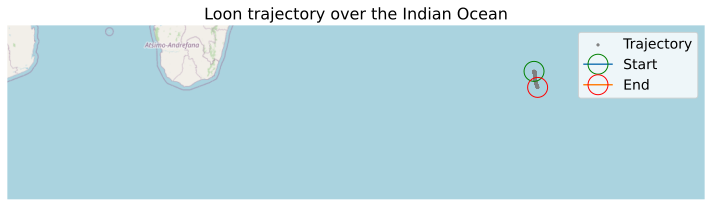

In [6]:
ac = wi_df[["longitude", "latitude"]].values
min_lat = ac[:, 1].min()  #
min_lon = ac[:, 0].min() - 25  #
max_lat = ac[:, 1].max()  #
max_lon = ac[:, 0].max()  #
map = smopy.Map((min_lat, min_lon, max_lat, max_lon), z=5)
ax = map.show_mpl(figsize=(10, 8), dpi=150)

wi_xs, wi_ys = map.to_pixels(wi_df.latitude, wi_df.longitude)


plt.scatter(wi_xs, wi_ys, s=5, color="gray", alpha=1, label="Trajectory")

plt.plot(
    wi_xs[:1],
    wi_ys[:1],
    marker="o",
    markersize=20,
    markerfacecolor="none",
    markeredgecolor="green",
    label="Start",
)
plt.plot(
    wi_xs[-1:],
    wi_ys[-1:],
    marker="o",
    markersize=20,
    markerfacecolor="none",
    markeredgecolor="red",
    label="End",
)


plt.legend(fontsize=14)
plt.title("Loon trajectory over the Indian Ocean", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
_ = plt.ylabel("Latitude", fontsize=12)

### Load or Train the GPT model

In [7]:
model_dir = "model-loon"
epochs = 5

################################################################################
# To run in fast mode, set env var NOTEBOOK_FAST_RUN=1 prior to starting Jupyter
################################################################################
if os.environ.get("NOTEBOOK_FAST_RUN", "0") != "0":
    epochs = 1

    display(
        Markdown(
            '<p style="color:firebrick; background-color:yellow; font-weight:bold">'
            "NOTE: notebook runs in fast mode. Train for 1x epoch only. Results may differ."
        )
    )
################################################################################

config = {
    "train_config": {
        "epochs": epochs,
        "batch_size": 512,
        "embedding_dim": 512,
        "gpt_n_layer": 1,
        "gpt_n_head": 1,
        "learning_rate": 6e-4,
        "num_workers": 0,
        "lr_decay": True,
    }
}
builder = wi.GPTBuilder(tokenizer, model_dir, config)

<p style="color:firebrick; background-color:yellow; font-weight:bold">NOTE: notebook runs in fast mode. Train for 1x epoch only. Results may differ.

Start GPT model training.

Default hyperparam is located at `src/a2rl/config.yaml`

In [8]:
# %%time
model_fname = os.path.join(model_dir, builder.model_name)
if os.path.exists(model_fname):
    print(f"Will load the GPT model from {model_fname}")
    builder.load_model()
else:
    print("Training the GPT model")
    builder.fit()

Training the GPT model


2023-05-22 10:07:50.560 | INFO     | a2rl.simulator:fit:753 - {'epochs': 1, 'batch_size': 512, 'embedding_dim': 512, 'gpt_n_layer': 1, 'gpt_n_head': 1, 'learning_rate': 0.0006, 'num_workers': 0, 'lr_decay': True}


  0%|          | 0/13 [00:00<?, ?it/s]

2023-05-22 10:08:31.661 | INFO     | a2rl.simulator:fit:787 - Training time in mins: 0.68


### Instantiate the Simulator Instance
To create a simulator, we need pass in the tokenzier and the GPT model wrapped inside `whatif.Simulator.GPTBuilder`

In [9]:
simulator = wi.Simulator(tokenizer, builder.model)

## Planning Ballon Trajectory

### Preparation
First we will find out the column names of SARS'

In [10]:
col_names = tokenizer.df.sar_d

In [11]:
dim_states = len(col_names["states"])
dim_states

10

In [12]:
rewards_cols = tokenizer.df.sar_d["rewards"]
rewards_cols

['dist_to_station', 'value']

In [13]:
action_cols = tokenizer.df.sar_d["actions"]
action_cols

['acs', 'is_daytime']

In [14]:
nb_actions = len(tokenizer.df_tokenized[action_cols[0]].unique())
nb_actions

2

Calculate the total number of dataframe tokens per SAR

In [15]:
sar_row_len = dim_states + len(rewards_cols) + len(action_cols)
sar_row_len

14

In [16]:
block_size = BLOCK_SIZE_ROW * sar_row_len
block_size

56

In [17]:
def recover_raw_reward(custom_context, my_action, reward):
    """
    return the untokenized (raw) values of both immediate_reward and reward_to_go (Q-value or SARSA)
    """
    prev_states = custom_context[-dim_states:]
    seq = np.hstack([prev_states, my_action, reward])
    dft = tokenizer.from_seq_to_dataframe(seq)
    ttt = dft[rewards_cols[:]].loc[0].values
    return ttt[0], ttt[1], dft  # 0 is immediate reward, 1 is the reward-to-go

In [18]:
def create_new_context(custom_context, my_action, reward, next_states):
    """
    Append new actions, reward and next_states to the current context
    in order to generate the new context
    """
    return np.hstack([custom_context, my_action, reward, next_states])

## Behaviour Cloning
First we use the `a2rl.Simulator.sample` API obtain "recommended" actions based on the distribution learned from the dataset.
We then apply selected actions to rollout the next step using the `a2rl.Simulator.lookahead` API.
We do this Rollout for each step throughout the entire trajectory.

We set the prediction horizon to 100 in order to limit the computation time of this example. If you run this notebook on a GPU machine, feel free to increase the horizon.

In [19]:
horizon = 50  # set the planning horizon
nb_runs = 1
start_step = 2000

################################################################################
# To run in fast mode, set env var NOTEBOOK_FAST_RUN=1 prior to starting Jupyter
################################################################################
if os.environ.get("NOTEBOOK_FAST_RUN", "0") != "0":
    start_step = 350

    display(
        Markdown(
            '<p style="color:firebrick; background-color:yellow; font-weight:bold">'
            "NOTE: notebook runs in fast mode. Use only a fraction of data. Results may differ."
        )
    )
################################################################################

start_step = min(start_step, wi_df.shape[0] - 1)
initial_simulation_context = tokenizer.df_tokenized.iloc[start_step : start_step + 1].values[0][:10]

<p style="color:firebrick; background-color:yellow; font-weight:bold">NOTE: notebook runs in fast mode. Use only a fraction of data. Results may differ.

In [20]:
accum_cost_list = []
non_accum_cost_list = []
raw_state_list = []
context_block_size = (
    block_size * BLOCK_SIZE_ROW
)  # make the context length longter than the block_size length
for _ in range(nb_runs):
    accum_cost = [0]
    non_accum_cost = [0]
    custom_context = initial_simulation_context
    raw_states = []
    for i in tqdm(range(horizon)):
        # obtain a valid "random" action
        if len(custom_context) > block_size:
            truncated_custom_context = custom_context[-block_size:]
        else:
            truncated_custom_context = custom_context
        recommendation_df = simulator.sample(truncated_custom_context, max_size=1, as_token=True)
        my_action = recommendation_df[action_cols].loc[0].values

        # use lookahead to build up the context
        if len(custom_context) > context_block_size:
            truncated_custom_context = custom_context[-context_block_size:]
        else:
            truncated_custom_context = custom_context
        # print('len(truncated_custom_context) = ', len(truncated_custom_context))
        reward, next_states = simulator.lookahead(truncated_custom_context, list(my_action))
        immediate_cost, _, raw_state = recover_raw_reward(
            truncated_custom_context, my_action, reward
        )
        accum_cost.append(accum_cost[-1] + immediate_cost)
        non_accum_cost.append(immediate_cost)
        raw_states.append(raw_state)
        custom_context = create_new_context(custom_context, my_action, reward, next_states)
        # print('len(custom_context) = ', len(custom_context))
    accum_cost_list.append(accum_cost)
    non_accum_cost_list.append(non_accum_cost)
    raw_state_list.append(raw_states)

  0%|          | 0/50 [00:00<?, ?it/s]

### Reconstruct the predicted trajectory 

In [21]:
sample = pd.concat(raw_state_list[0])

### Compute coordinates based on predicted velocities
The current ballon locations (latitude and longitude coordinates) are not part of the states, but they can be calculated from previous location and the two velocities, which are states predicted by `Whatif simulator`. Doing this auto-regressively will reconstruct locations starting from the initial position til the end of the prediction horizon.

In [22]:
avg_time_resolution = (
    (wi_df["timestamp"][wi_df.shape[0] - 1] - wi_df["timestamp"][0]) / wi_df.shape[0] / 1000
)  # millisecs to secs
meters_in_degree = 0.001 / 111  # assuming great circle
init_lon = wi_df["longitude"][start_step]  # initial location
init_lat = wi_df["latitude"][start_step]
lons = [init_lon]
lats = [init_lat]

for speed_lon, speed_lat in zip(sample.velocity_u, sample.velocity_v):
    lons.append(
        lons[-1] + speed_lon * avg_time_resolution * meters_in_degree
    )  # convert distance from meters to degrees
    lats.append(lats[-1] + speed_lat * avg_time_resolution * meters_in_degree)

sample["dist_u"] = lons[1:]
sample["dist_v"] = lats[1:]

### Plot trajectories

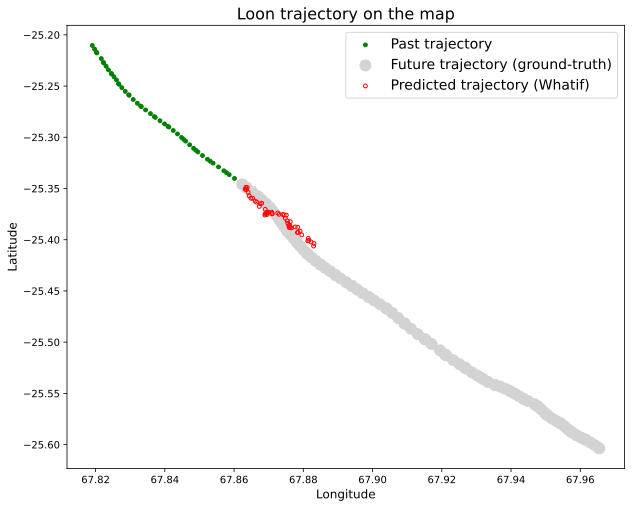

In [23]:
plt.scatter(
    wi_df["longitude"][start_step - 500 : start_step],
    wi_df["latitude"][start_step - 500 : start_step],
    s=15,
    color="green",
    alpha=1,
    label="Past trajectory",
)

plt.scatter(
    wi_df["longitude"][start_step : start_step + 200],
    wi_df["latitude"][start_step : start_step + 200],
    s=120,
    color="lightgray",
    alpha=1,
    label="Future trajectory (ground-truth)",
)

plt.scatter(
    sample["dist_u"],
    sample["dist_v"],
    s=15,
    color="none",
    edgecolor="red",
    label="Predicted trajectory (Whatif)",
)

plt.legend(fontsize=14)
plt.title("Loon trajectory on the map", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
_ = plt.ylabel("Latitude", fontsize=12)

### Plot states (temperature and altitude) and action (ACS)

We compare the states between reality and Whatif simulation, and we found them to be largely consistent. In particular, the action is identical.

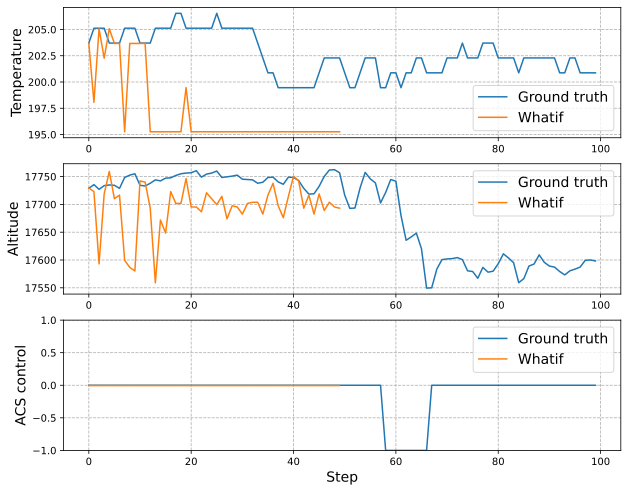

In [24]:
fig, axs = plt.subplots(3)
axs[0].plot(wi_df["temperature"][start_step : start_step + 100].values, label="Ground truth")
axs[0].plot(sample.temperature.values, label="Whatif")
axs[0].set_ylabel("Temperature", fontsize=14)
axs[0].legend(fontsize=14)
axs[0].grid(ls="--")
axs[1].plot(wi_df["altitude"][start_step : start_step + 100].values, label="Ground truth")
_ = axs[1].plot(sample.altitude.values, label="Whatif")
# axs[1].set_xlabel("Step", fontsize=14)
axs[1].set_ylabel("Altitude", fontsize=14)
axs[1].legend(fontsize=14)
axs[1].grid(ls="--")
axs[2].plot(wi_df["acs"][start_step : start_step + 100].values, label="Ground truth")
_ = axs[2].plot(sample.acs.values, label="Whatif")
_ = axs[2].set_ylim([-1, 1])
axs[2].set_xlabel("Step", fontsize=14)
axs[2].set_ylabel("ACS control", fontsize=14)
axs[2].legend(fontsize=14)
axs[2].grid(ls="--")

## Counter Factual (Whatif?)
From the above plot, we understand that the actual control action during the 100-step horizon has always been 0 (neither acending nor descending). But **what if** we send the "descending" control to the balloon? To explore this counter-factual effect, we force the control to `-1` (i.e. always descending), which corresponds to the token `1000`, and re-run the `Whatif` simulator as before (thus using the `lookahead` API to rollout the 100-step trajectory).

In [25]:
accum_cost_list = []
non_accum_cost_list = []
raw_state_list = []
context_block_size = block_size * BLOCK_SIZE_ROW
hardcoded_action = np.array([1000, 1100])  # hardcode the control action
for _ in range(nb_runs):
    accum_cost = [0]
    non_accum_cost = [0]
    custom_context = initial_simulation_context
    raw_states = []
    for i in tqdm(range(horizon)):
        # obtain a valid "random" action
        if len(custom_context) > block_size:
            truncated_custom_context = custom_context[-block_size:]
        else:
            truncated_custom_context = custom_context

        # use lookahead to build up the context
        if len(custom_context) > context_block_size:
            truncated_custom_context = custom_context[-context_block_size:]
        else:
            truncated_custom_context = custom_context
        # print('len(truncated_custom_context) = ', len(truncated_custom_context))
        reward, next_states = simulator.lookahead(truncated_custom_context, list(hardcoded_action))
        immediate_cost, _, raw_state = recover_raw_reward(
            truncated_custom_context, hardcoded_action, reward
        )
        accum_cost.append(accum_cost[-1] + immediate_cost)
        non_accum_cost.append(immediate_cost)
        raw_states.append(raw_state)
        custom_context = create_new_context(custom_context, hardcoded_action, reward, next_states)
        # print('len(custom_context) = ', len(custom_context))
    accum_cost_list.append(accum_cost)
    non_accum_cost_list.append(non_accum_cost)
    raw_state_list.append(raw_states)

  0%|          | 0/50 [00:00<?, ?it/s]

In [26]:
sample02 = pd.concat(raw_state_list[0])
lons02 = [init_lon]
lats02 = [init_lat]

for speed_lon, speed_lat in zip(sample02.velocity_u, sample02.velocity_v):
    lons02.append(lons02[-1] + speed_lon * avg_time_resolution * meters_in_degree)
    lats02.append(lats02[-1] + speed_lat * avg_time_resolution * meters_in_degree)

sample02["dist_u"] = lons02[1:]
sample02["dist_v"] = lats02[1:]

### Plot counter-factual (whatif) trajectories

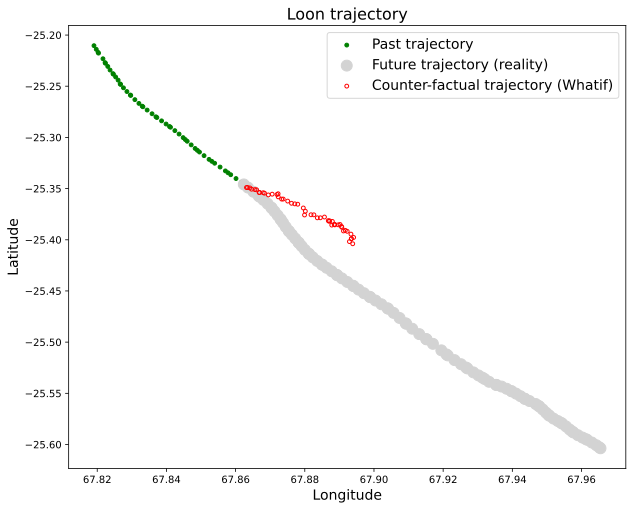

In [27]:
plt.scatter(
    wi_df["longitude"][start_step - 500 : start_step],
    wi_df["latitude"][start_step - 500 : start_step],
    s=15,
    color="green",
    alpha=1,
    label="Past trajectory",
)

plt.scatter(
    wi_df["longitude"][start_step : start_step + 200],
    wi_df["latitude"][start_step : start_step + 200],
    s=120,
    color="lightgray",
    alpha=1,
    label="Future trajectory (reality)",
)

plt.scatter(
    sample02["dist_u"],
    sample02["dist_v"],
    s=15,
    color="none",
    edgecolor="red",
    label="Counter-factual trajectory (Whatif)",
)

plt.legend(fontsize=14)
plt.title("Loon trajectory", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
_ = plt.ylabel("Latitude", fontsize=14)

As shown in the plot above, the counter-factual trajectory (red) predicted by Whatif eventually deviates from the expected trajectory had it followed the original action control. This is interesting because we did not change anything but the altitude control, yet its consequence shows up in the horizontal (longitude-latitude) plane. This suggests that the simulator **may have learned something consistent with the underlying physics** from the data. That is, winds at different altitudes may blow the ballon towards different directions horizontally, thus deviating from the trajectory at its original altitude.

### Plot counter-factual states (temperature and altitude) and action (ACS)

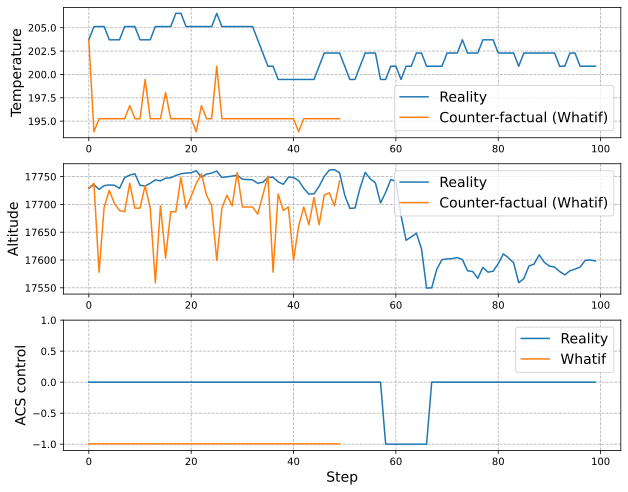

In [28]:
fig, axs = plt.subplots(3)
axs[0].plot(wi_df["temperature"][start_step : start_step + 100].values, label="Reality")
axs[0].plot(sample02.temperature.values, label="Counter-factual (Whatif)")
axs[0].set_ylabel("Temperature", fontsize=14)
axs[0].legend(fontsize=14)
axs[0].grid(ls="--")
axs[1].plot(wi_df["altitude"][start_step : start_step + 100].values, label="Reality")
_ = axs[1].plot(sample02.altitude.values, label="Counter-factual (Whatif)")
# axs[1].set_xlabel("Step", fontsize=14)
axs[1].set_ylabel("Altitude", fontsize=14)
axs[1].legend(fontsize=14)
axs[1].grid(ls="--")
axs[2].plot(wi_df["acs"][start_step : start_step + 100].values, label="Reality")
_ = axs[2].plot(sample02.acs.values, label="Whatif")
_ = axs[2].set_ylim([-1.1, 1])
axs[2].set_xlabel("Step", fontsize=14)
axs[2].set_ylabel("ACS control", fontsize=14)
axs[2].legend(fontsize=14)
axs[2].grid(ls="--")

The above plot shows that when we set the control to "*continuous descend*" for 100 steps, the simulator reacted it by reducing the altitude of the ballon. This again shows that the simulator may have learned correct physics.